<a href="https://colab.research.google.com/github/Nishan-Charlie/Her2_Histopathology/blob/main/Her2Binary_Vgg19_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D,Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import AUC

# numpy
import numpy as np

# Ploting
import matplotlib.pyplot as plt

# System
import os
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning)
%matplotlib inline
random.seed(42)

In [ ]:
# Binary Her2 IHC dataset (POS & NEG)
base = "/content/drive/MyDrive/Colab Notebooks/FYP/Her2 - 2classesv02"

In [ ]:
# Initialising training and test paths
train_path = os.path.join(base, 'Train')
test_path =  os.path.join(base, 'Test')

# Classes
classes = os.listdir(train_path)
print(classes)

['Neg', 'Pos']


In [ ]:
dataGenerator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input, validation_split=0.6,
    rotation_range=180,      # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2, # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,        # Apply shear transformations
    horizontal_flip=True,   # Randomly flip images horizontally
    )


train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input, rotation_range=180,
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2, # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,        # Apply shear transformations
    horizontal_flip=True).flow_from_directory(directory=train_path, target_size=(224, 224), classes=classes, batch_size=32)


valid_batches = dataGenerator.flow_from_directory(directory= test_path, target_size = (224,224),classes = classes, batch_size = 16,class_mode='categorical',subset='validation')

test_batches = dataGenerator.flow_from_directory(directory = test_path, target_size=(224,224),classes = classes, batch_size = 16, shuffle = False,class_mode='categorical',subset='training')


Found 1606 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 96 images belonging to 2 classes.


In [ ]:
# Function for ploting the confusion matrix
def plot_confusion_matrix(cm, classes, normalize= False, title='Confusin Matrix', cmap = plt.cm.Blues):
  plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks,classes)

  if normalize:
    cm = cm.astype('flot')/ cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")

  thresh = cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i,cm[i,j],
             horizontalalignment = "center",
             color="white" if cm[i,j]> thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
vgg19_model = tf.keras.applications.vgg19.VGG19(weights="imagenet",input_shape=(224,224,3))

vgg19_model.summary()

574710816/574710816 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
model = Sequential()
for layer in vgg19_model.layers[:-1]:
  model.add(layer)

# only train the fully connected layers and last convolutional block
for layer in model.layers[:-9]:
  layer.trainable = False

model.add(BatchNormalization())
model.add(Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(2, activation='softmax'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=5,          # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored quantity

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy', AUC()])

In [ ]:
history = model.fit(x= train_batches, validation_data = valid_batches, epochs = 50, callbacks=[early_stopping])

In [ ]:
model.save("/content/drive/MyDrive/Medical Imaging/Model folder"+"/vgg19_her2binar_class.h5")

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [ ]:
import json

# Convert the history to a dictionary
history_dict = history.history

# Save the dictionary as a JSON file
with open('history.json', 'w') as f:
    json.dump(history_dict, f)

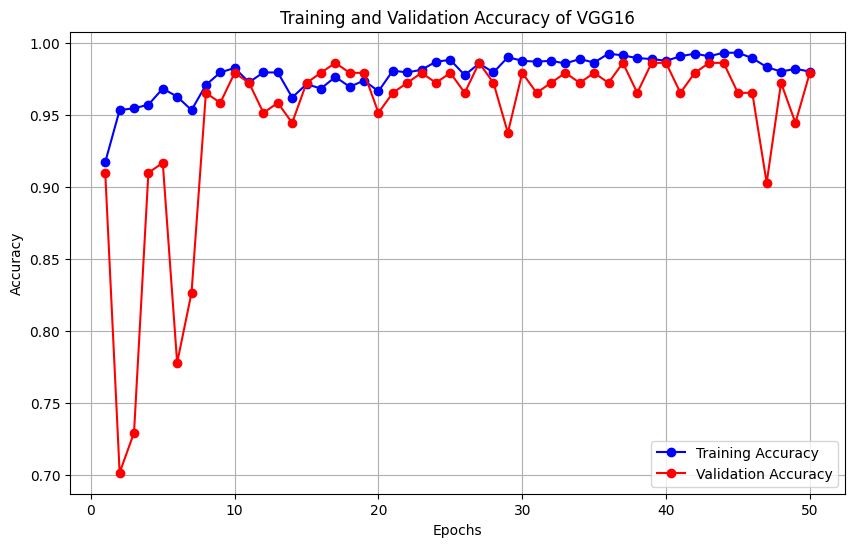

In [ ]:
# Extract training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, 51)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

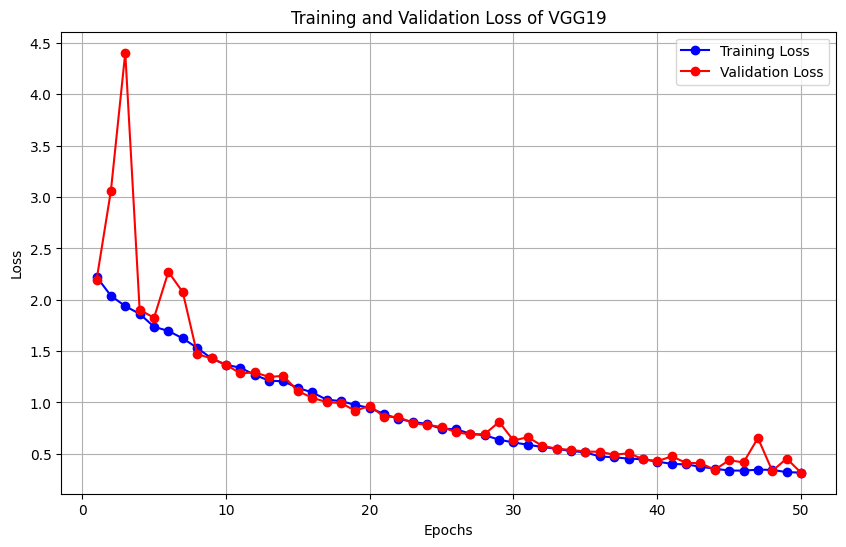

In [ ]:

# Extract training and validation accuracy
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a range of epochs
epochs = range(1, 51)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss of VGG19')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_accuracy ,test_auc= model.evaluate(test_batches)
print("Testing Loss:", test_loss)
#print("AUC", AUC)
print("Testing Accuracy:", test_accuracy)

6/6 [==============================] - 23s 4s/step - loss: 0.3154 - accuracy: 0.9792 - auc_1: 0.9985
Testing Loss: 0.3154039680957794
Testing Accuracy: 0.9791666865348816


6/6 [==============================] - 3s 368ms/step


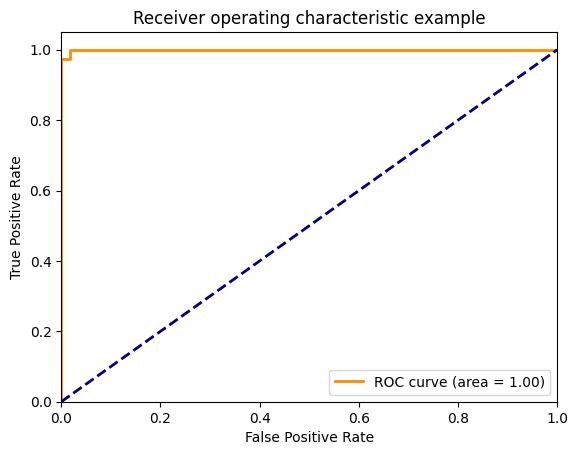

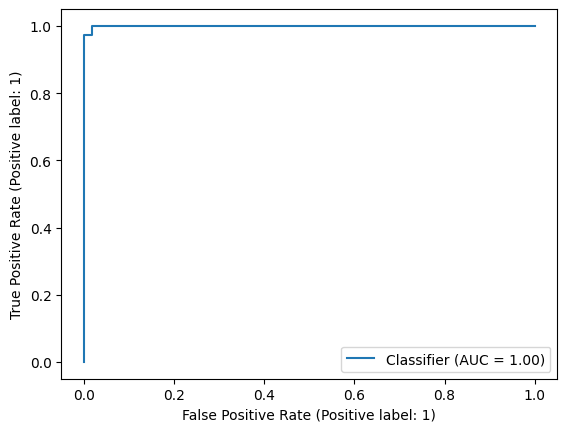

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Get predictions
y_pred = model.predict(test_batches)

# Get true labels
y_true = test_batches.labels

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Display ROC curve using sklearn
RocCurveDisplay.from_predictions(y_true, y_pred[:, 1])
plt.show()


6/6 [==============================] - 2s 351ms/step
Confusion matrix, without normalization


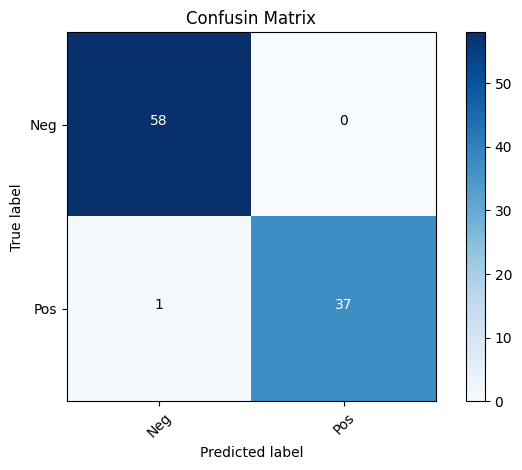

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

# Get predictions
y_pred = model.predict(test_batches)

# Get true labels
y_true = test_batches.labels

# Calculate confusion matrix
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Plot confusion matrix
plot_confusion_matrix(cm, classes=classes)


#SHAP Explainer

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Medical Imaging/Model folder"+"/vgg19_her2binar_class.h5")

In [ ]:
!pip install shap==0.36

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for shap: filename=shap-0.36.0-cp310-cp310-linux_x86_64.whl size=452854 sha256=35dc5f9966d1c0eedeaf4a13afaf488845027cf870866102ebbd708844a985d9
  Stored in directory: /root/.cache/pip/wheels/37/c7/c4/f9d2c3aa5f27703ecf4253ebd0a0ea954ba5e5fb982f772157
Successfully built shap


In [ ]:
import shap

/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

In [ ]:
new_batch = ImageDataGenerator(validation_split=0.8).flow_from_directory(directory=test_path, target_size = (224,224),classes = classes, batch_size = 16,class_mode='categorical',subset='training')

Found 48 images belonging to 2 classes.


In [ ]:
images,labels=next(new_batch)
image_number = 12
actual_class = classes[np.argmax(labels[image_number])]
print(actual_class)

Neg


In [ ]:
single=np.expand_dims(images[image_number], axis=0)
pred_single=model.predict(single)
pred_single=np.argmax(pred_single, axis=-1)
classes[pred_single[0]]
print(pred_single,labels[image_number])
print("pridicted class:",classes[pred_single[0]])
print("Actual class:",classes[np.argmax(labels[image_number])])

1/1 [==============================] - 0s 28ms/step
[0] [1. 0.]
pridicted class: Neg
Actual class: Neg


In [ ]:

def rescale_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

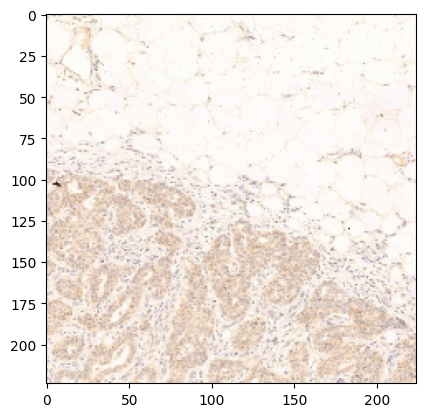

In [ ]:
normalized_img = rescale_image(images[image_number] )

plt.imshow(normalized_img)
plt.show()

In [ ]:
preprocessed_images = preprocess_input(images)
explainer = shap.GradientExplainer(model, preprocessed_images)
gradinetExplainer_shap_values = explainer.shap_values(preprocessed_images[image_number:image_number+1])
gradinetExplainer_shap_values = np.array(gradinetExplainer_shap_values)
print(gradinetExplainer_shap_values.shape)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


(2, 1, 224, 224, 3)


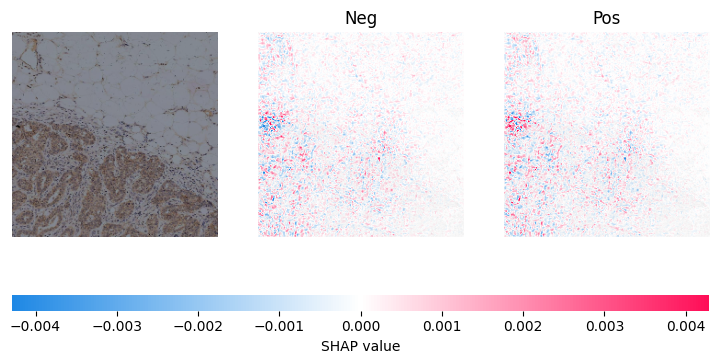

In [ ]:
# Plot the SHAP values
shap.image_plot([gradinetExplainer_shap_values[i] for i in range(2)], images[image_number:image_number+1], labels=  np.array(classes).reshape(1, 2))

#LIME Explainer

In [ ]:
!pip install lime

In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
def predict_fn(images):
    # Preprocess the images using VGG19's preprocessing function
    preprocessed_images = preprocess_input(images)
    # Get predictions from the model
    preds = model.predict(preprocessed_images)
    return preds

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


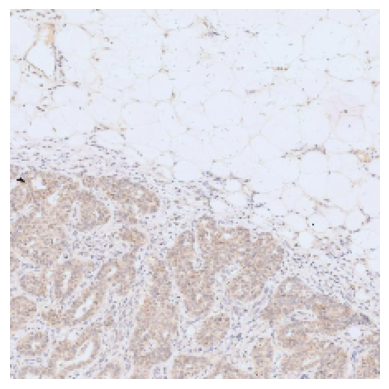

In [ ]:
explainer = lime_image.LimeImageExplainer(random_state=42)
#single= np.expand_dims(images[image_number], axis=0)
explanation = explainer.explain_instance(rescale_image(images[image_number]).astype('double'),predict_fn)
plt.imshow(rescale_image(images[image_number]))
plt.axis(False)
n=(base+"LIMEOriginal1.png")
plt.savefig(n, dpi=1200)

0


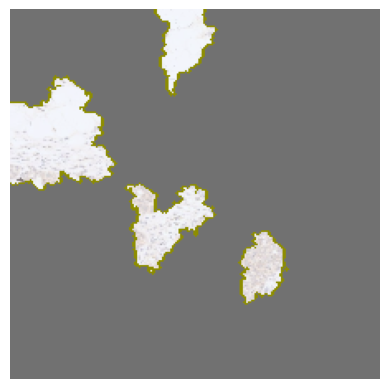

In [ ]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=True,
                                            hide_rest=True)

print(explanation.top_labels[0])
lime_img = rescale_image(mark_boundaries(temp + 0.8, mask))
plt.imshow(lime_img)
plt.axis(False)
n=(base+"LIMEMask.png")
plt.savefig(n, dpi=1200)

In [ ]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=3,
                                            hide_rest=True)

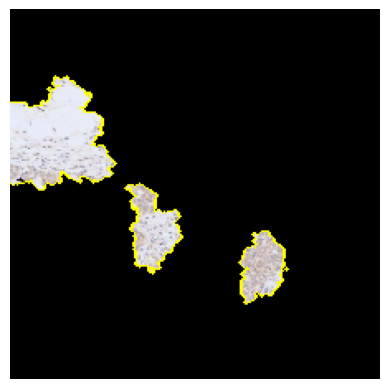

In [ ]:
plt.imshow(mark_boundaries(temp, mask))
plt.axis(False)
n=(base+"LIMEWithBoundary.png")
plt.savefig(n, dpi=1200)

#GradCAM Visualisation

In [ ]:
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.models import Model


def VizGradCAM(model, image, interpolant=0.5, plot_results=True):

    # Sanity Check
    assert (
        interpolant > 0 and interpolant < 1
    ), "Heatmap Interpolation Must Be Between 0 - 1"

    last_conv_layer = next(
        x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D)
    )
    target_layer = model.get_layer(last_conv_layer.name)
    print(target_layer)

    original_img = image
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)

    # Obtain Prediction Index
    prediction_idx = np.argmax(prediction)

    # Compute Gradient of Top Predicted Class
    with tf.GradientTape() as tape:
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        print("prediction", prediction)
        # Obtain the Prediction Loss
        loss = prediction[:, prediction_idx]

    # Gradient() computes the gradient using operations recorded
    # in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    # Obtain the Output from Shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    # Obtain Depthwise Mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    # Create a 7x7 Map for Aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    # Multiply Weights with Every Layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    # Resize to Size of Image
    activation_map = cv2.resize(
        activation_map.numpy(), (original_img.shape[1], original_img.shape[0])
    )

    # Ensure No Negative Numbers
    activation_map = np.maximum(activation_map, 0)

    # Convert Class Activation Map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (
        activation_map.max() - activation_map.min()
    )
    activation_map = np.uint8(255 * activation_map)

    # Convert to Heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    # Superimpose Heatmap on Image Data
    original_img = np.uint8(
        (original_img - original_img.min())
        / (original_img.max() - original_img.min())
        * 255
    )

    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Enlarge Plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(
            np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))
        )
        n=(base+"GradCAM"+str(1)+".png")
        plt.savefig(n, dpi=1200)
    else:
        return cvt_heatmap

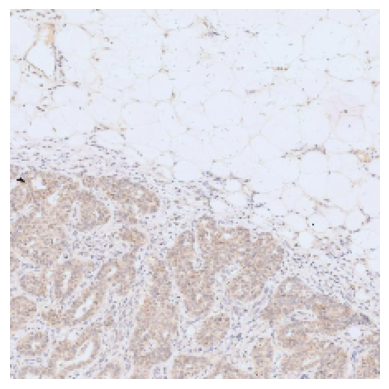

In [ ]:
selected_img = rescale_image(images[image_number])
plt.axis(False)
plt.imshow(selected_img)

(224, 224, 3)
1/1 [==============================] - 0s 62ms/step
prediction tf.Tensor([[0.9855962  0.01440389]], shape=(1, 2), dtype=float32)


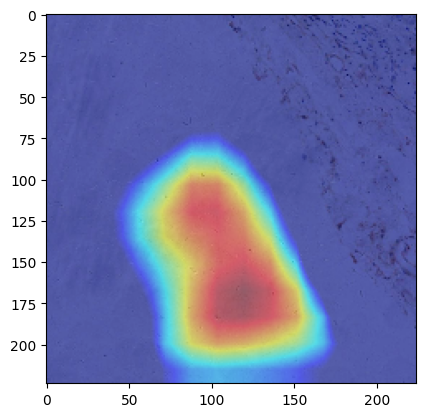

In [ ]:
selected_img =images[image_number]
print(selected_img.shape)

VizGradCAM(model, selected_img)

#H&E Dataset

In [ ]:
HE_base ="/content/drive/MyDrive/Medical Imaging/BCI_binary/HE"

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Medical Imaging/Model folder"+"/vgg19_her2binar_class.h5")

In [ ]:
# Initialising training and test paths
train_path = os.path.join(HE_base, 'train')
test_path =  os.path.join(HE_base, 'test')

# Classes
classes = os.listdir(train_path)
print(classes)

['neg', 'pos']


In [ ]:
dataGenerator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input, validation_split=0.6,
    rotation_range=180,      # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2, # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,        # Apply shear transformations
    horizontal_flip=True,   # Randomly flip images horizontally
    )


train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input, rotation_range=180,
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2, # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,        # Apply shear transformations
    horizontal_flip=True).flow_from_directory(directory=train_path, target_size=(224, 224), classes=classes, batch_size=32)


valid_batches = dataGenerator.flow_from_directory(directory= test_path, target_size = (224,224),classes = classes, batch_size = 16,class_mode='categorical',subset='validation')

test_batches = dataGenerator.flow_from_directory(directory = test_path, target_size=(224,224),classes = classes, batch_size = 16, shuffle = False,class_mode='categorical',subset='training')


Found 3896 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 392 images belonging to 2 classes.


In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy', AUC()])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 410,947,912 (1.53 GB)

 Trainable params: 133,451,522 (509.08 MB)

 Non-trainable params: 10,593,344 (40.41 MB)

 Optimizer params: 266,903,046 (1018.15 MB)

In [ ]:
history = model.fit(x= train_batches, validation_data = valid_batches, callbacks=[early_stopping],epochs = 100)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 2797s 22s/step - accuracy: 0.6526 - auc: 0.6723 - loss: 1.2046 - val_accuracy: 0.7248 - val_auc: 0.7566 - val_loss: 1.2629
Epoch 2/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 115s 901ms/step - accuracy: 0.7077 - auc: 0.7436 - loss: 0.8340 - val_accuracy: 0.3726 - val_auc: 0.3640 - val_loss: 1.3236
Epoch 3/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 116s 916ms/step - accuracy: 0.7232 - auc: 0.7544 - loss: 0.8171 - val_accuracy: 0.7453 - val_auc: 0.7657 - val_loss: 0.8035
Epoch 4/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 138s 873ms/step - accuracy: 0.7245 - auc: 0.7956 - loss: 0.7688 - val_accuracy: 0.7248 - val_auc: 0.8007 - val_loss: 0.7564
Epoch 5/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 147s 921ms/step - accuracy: 0.7673 - auc: 0.8450 - loss: 0.6970 - val_accuracy: 0.7470 - val_auc: 0.8121 - val_loss: 0.7344
Epoch 6/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 136s 879ms/step - accuracy: 0.7884 - auc: 0.8509 - loss: 0.6815 - val_accuracy: 0.7692 - val_auc: 0.8452 - val_loss: 0.6928
Epoch 7/100
122/122 ━━━

KeyboardInterrupt: 

In [ ]:
# Extract training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create a range of epochs
epochs = range(0, len(training_accuracy))

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy_H&E')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy_H&E')
plt.title('Training and Validation Accuracy of VGG19_H&E')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/Medical Imaging/Model folder"+"/vgg19_her2binar_class_HE.h5")

In [ ]:
# Extract training and validation accuracy
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a range of epochs
epochs = range(0, len(training_loss))

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss_H&E')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss_H&E')
plt.title('Training and Validation Loss of VGG19_H&E')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_accuracy ,test_auc= model.evaluate(test_batches)
print("Testing Loss:", test_loss)
#print("AUC", AUC)
print("Testing Accuracy: ", test_accuracy)

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Get predictions
y_pred = model.predict(test_batches)

# Get true labels
y_true = test_batches.labels

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Display ROC curve using sklearn
RocCurveDisplay.from_predictions(y_true, y_pred[:, 1])
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

# Get predictions
y_pred = model.predict(test_batches)

# Get true labels
y_true = test_batches.labels

# Calculate confusion matrix
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Plot confusion matrix
plot_confusion_matrix(cm, classes=classes)
